# Journalism-Focused AI Assistant

![Journalism Focused AI Assistant](../images/journalism_focused_ai_assistant_langgraph.png)

## Overview

This notebook introduces an AI-powered assistant designed specifically for journalists, tackling challenges like misinformation, biased reporting, and information overload. With tools for fact-checking, tone analysis, summarization, and more, it uses AI tools to enhance the accuracy and efficiency of journalistic work.


## Motivation

Journalism plays a vital role in upholding democracy, but modern challenges like the flood of online misinformation and subtle biases can undermine trust in reporting. Journalists often face the daunting task of making sense of huge volumes of data under tight deadlines. This notebook equips journalists with tools to:

- **Verify claims** through reliable fact-checking.
- **Detect tone and biases** to maintain balanced storytelling.
- **Simplify the review process** with concise and accurate summaries, as well as grammar checks.

The ultimate goal is to support ethical reporting and uphold the integrity of the information we rely on every day.

## Key Components

1. **Language Models**: Get insights and generate responses using advanced models like `Llama 3.1/3.2` and `gpt-4o-mini`.
2. **Web Search Integration**: Fetch reliable data from `DuckDuckGo’s` search API to strengthen the research process.
3. **Document Parsing**: Extract text from PDFs and web pages with tools like PyMuPDFLoader and WebBaseLoader, enhanced by BeautifulSoupTransformer.
4. **Structured Outputs**: Receive responses in a clean, JSON format for consistency and precision.
5. **Text Splitting and Summarization**: Break down long articles into digestible summaries using RecursiveCharacterTextSplitter.
6. **Tailored Prompts and Examples**: Use custom prompts and few-shot prompting to guide the AI in providing meaningful results.
7. **LangGraph Workflow**: Tie everything together into a seamless, easy-to-use workflow.

## Method Details

### Setting Up the Environment
- Import necessary libraries.
- Configure any API keys and data sources.

### Summarization
- Pinpoint key ideas in long articles or reports.
- Generate clear, concise summaries for quicker understanding.

### Fact-Checking
- Input claims or statements to analyze.
- Search credible sources and compile relevant evidence.
- Categorize claims (e.g., confirmed, refuted, or unverifiable) and provide detailed explanations.

### Tone and Bias Analysis
- Process text to determine sentiment—positive, neutral, or negative.
- Spot and highlight biased language or phrasing.

### Quote Extraction
- Detect direct quotes and their sources to add transparency to your reporting.

### Grammar and Bias Review
- Identify grammar errors and subtle biases, ensuring content is polished and fair.

### LangGraph Workflow Integration
- Use LangGraph to connect all these tools into one powerful workflow:
- Define nodes for each task, from analysis to report generation.
- Pass data seamlessly between tasks for smooth processing.
- Test the workflow on a sample article.

### Report Generation
- Combine all findings into a well-organized report that’s easy to read and share.

### Additional Considerations
- Discuss limitations, potential improvements, or specific use cases.

## This Journalism-Focused AI Assistant is all about helping journalists do their best work by:
- **Improving Accuracy**: Fact-checking tools ensure your claims are backed by evidence.
- **Boosting Efficiency**: Summarization and workflows save valuable time.
- **Adding Transparency**: Features like quote extraction and structured reports build trust.
- **Promoting Ethical Reporting**: Tone and bias analysis helps maintain objectivity.

By bringing these features together, this tool empowers journalists to focus on what they do best: telling meaningful stories.

## Setup and Imports

First, we'll import the necessary modules and set up our environment.

In [ ]:
# Required packages
# %pip install beautifulsoup4 duckduckgo-search langchain langgraph langchain-ollama langchain-openai langchain-openai python-dotenv

In [ ]:
import os
import pprint
import time

from pathlib import Path
from functools import lru_cache
from dotenv import load_dotenv
from typing import Optional, List, TypedDict
from duckduckgo_search import DDGS
from IPython.display import display, Image

from langchain_openai import ChatOpenAI
from langchain import PromptTemplate
from langchain_community.document_loaders.pdf import PyMuPDFLoader
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_transformers import BeautifulSoupTransformer
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# Define the data path
data_path = Path(os.getcwd()).parent / "data"

# Duckduckgo search
ddgs = DDGS()

## Initialize Language Models

We will initialize the language models that can be used for testing.

For running Llama models, we use Ollama. A detailed tutorial on this is beyond the scope of this notebook, but you can refer to their repository for a [quickstart guide on Ollama](https://github.com/ollama/ollama).

In [68]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# llm = ChatOllama(model="llama3.1", temperature=0)
# llm = ChatOllama(model="llama3.2", temperature=0)

## Data Setup

For this, I used the `gpt-4o` model to generate a sample article using the prompt below. Note that the information mentioned in the article is not to be taken seriously. The article will serve as input for summarization, fact-checking, tone analysis, quote extraction, and grammar and bias analysis modules, providing a basis for refining prompt responses.

We will take advantage of the `document_loaders` `langchain` module, specifically the `PyMuPDFLoader` for loading the text from a PDF file. 

`Prompt`:
Write an article designed for classification purposes, containing a variety of claims that fit into distinct but subtly presented categories: well-known and confirmed facts, refuted claims, unverifiable statements requiring further research, and vague or speculative assertions. The article should flow naturally without explicitly labeling these categories but ensure that each type of claim is clearly identifiable through its content and context. Use varied tones, including positive, critical, biased, or opinionated language, to differentiate the claims. Incorporate quotes to enhance realism and include occasional minor grammar errors or awkward phrasing for added authenticity.


In [69]:
# Pdf file path
file_path = data_path / "Sample AI Generated Article.pdf"

# Load the pdf file
pages = []
loader = PyMuPDFLoader(file_path)
for page in loader.lazy_load():
    pages.append(page)

#### Check the file contents and remove the new lines and tabs

For printing throughout the tutorial, I will sometimes use the built-in `pprint` package as it formats text and different data types in more human-readable forms.

In [70]:
def clean_page_content(page_content: str) -> str:
    """
    Clean the page content by removing new lines and tabs
    """
    page_content = page_content.replace("\n", " ")
    page_content = page_content.replace("\t", " ")
    return page_content

print("Page content before cleaning")
for page in pages:
    pprint.pprint(page.page_content[:100])
    

print("\nPage content after cleaning")
formatted_pages = []
for page in pages:
    page_content = clean_page_content(page.page_content)
    formatted_pages.append(page_content)
    pprint.pprint(page_content[:200])

# Combine all the pages into a single text
full_article_text = " ".join(formatted_pages)

Page content before cleaning
('The Mysterious Origins and Potential\n'
 'Impacts of the Halcyon Bird\n'
 'Introduction\n'
 'The halcyon bird, a su')
('Sailors’ Tales and Anecdotes\n'
 'Stories passed down through generations speak of sailors encountering h')
('"People are drawn to the idea of a creature that embodies serenity," says '
 'cultural historian\n'
 'Dr. Ste')

Page content after cleaning
('The Mysterious Origins and Potential Impacts of the Halcyon Bird '
 'Introduction The halcyon bird, a subject of fascination for centuries, is '
 'often celebrated as a symbol of tranquility and mythical wond')
('Sailors’ Tales and Anecdotes Stories passed down through generations speak '
 'of sailors encountering halcyon birds during times of storm and finding '
 'themselves inexplicably drawn to safety. Captain Ed H')
('"People are drawn to the idea of a creature that embodies serenity," says '
 'cultural historian Dr. Stephen Archer. "It’s a universal longing, especially '
 'in turbulen

## Helper Functions

In [71]:
def chunk_large_text(text, chunk_size=100000, overlap=1000):
    """
    Splits the input text into manageable chunks while maintaining context overlap.
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        separators=["\n\n", "\n", " ", ""]
    )
    return text_splitter.split_text(text)

## Summarizing Long Articles

Summarizing lengthy articles requires handling the constraints of token limits in models like `gpt-4o-mini` or `Llama 3.2/3.1`. These models can process only a limited amount of text at once, making **text splitting** a crucial step to ensure the analysis is thorough and no critical information is overlooked. While this notebook may not reach those token limits, the text-splitting approach is demonstrated as a proof of concept.

### Why Use Text Splitting?

Text splitting ensures the model can process lengthy content effectively by:
- Dividing large articles into manageable chunks (e.g., 100,000 tokens).
- Maintaining context through overlapping sections (e.g., 1,000 tokens).
- Preventing request rejections due to exceeding token limits.

### Tools and Techniques

- **Splitter**: The `RecursiveCharacterTextSplitter` from `langchain` is used for breaking down text into smaller chunks while preserving context and readability.
- **Custom Prompts**: Focus prompts on extracting key events, individuals, and statistics for precise summarization.
- **Step-by-Step Workflow**:
  1. Split the text into chunks.
  2. Summarize each chunk individually using the AI model.
  3. Combine the individual summaries into a cohesive and concise final summary.

### Benefits of This Approach

By leveraging text splitting and summarization workflows, even the longest articles can be processed effectively:
- **Accuracy**: Ensures no critical details are missed during summarization.
- **Efficiency**: Breaks down complex tasks into manageable pieces for faster results.
- **Consistency**: Maintains flow and context across the final summary.

This approach provides reliable and concise summaries for articles of any length, making it a powerful tool for handling extensive content with ease.



### Prepare the summarization pipelines

In [72]:
# Define the summarization prompt
summarization_prompt = PromptTemplate(
    input_variables=["text"],
    template=(
        "Summarize the provided article text focusing on the main events, key people involved, "
        "and any important statistics in 150-200 words. Use a neutral tone suitable for a journalistic report:\n\n"
        "Article text:\n{text}\n\n"
    )
)

# Define de combine summarization prompt
combine_summarization_prompt = PromptTemplate(
    input_variables=["summaries"],
    template=(
        "Combine the provided summaries into a single coherent summary that captures the main events, key people involved, "
        "and important statistics in 150-200 words. Use a neutral tone suitable for a journalistic report:\n\n"
        "Summaries:\n{summaries}\n\n"
    )
)

# Define the summarization pipeline
summarization_pipeline = summarization_prompt | llm

# Define the combine summarization pipeline
combine_summarization_pipeline = combine_summarization_prompt | llm

### Summarization helper functions

In [73]:
def combine_summaries(summaries: List[str]):
    """
    Combines multiple summaries into a single coherent summary.
    """
    # If the article is short, return the single summary
    if len(summaries) == 1:
        return summaries[0]
    
    # Combine the summaries into a single text
    summaries_text = ""
    for i, summary in enumerate(summaries):
        summaries_text += f"Summary {i + 1}:\n{summary}\n\n"
    
    # Generate a combined summary
    full_summary = combine_summarization_pipeline.invoke({"summaries": summaries_text})

    return full_summary


def summarize_article(article_text: str, article_chunks=None):
    """
    Summarize a full article text by splitting it into manageable chunks and generating summaries for each chunk.
    The individual summaries are then combined into a single coherent summary.
    """
    # Split the full article text into manageable chunks if not provided
    if not article_chunks:
        article_chunks = chunk_large_text(article_text)

    # Generate summaries for each chunk
    summaries = []
    for chunk in article_chunks:
        summary = summarization_pipeline.invoke({"text": chunk})
        summaries.append(summary.content)

    # Combine the individual summaries into a single coherent summary
    full_summary = combine_summaries(summaries)
    
    return full_summary

### Sample usage

In [74]:
summary_result = summarize_article(full_article_text)

print("\n\nSummary of the article")
pprint.pprint(summary_result)



Summary of the article
('The halcyon bird, often associated with tranquility and mythical narratives, '
 'has captivated human imagination for centuries. Rooted in Greek mythology, '
 'particularly the story of Alcyone, the term "halcyon" refers to certain '
 'kingfisher species, primarily found in tropical regions. Dr. Elena Marquez, '
 'an avian biology professor, clarifies that while these birds exhibit calm '
 'behaviors, they are adaptations for survival rather than evidence of '
 'supernatural abilities. Modern science, represented by marine biologist Dr. '
 'Robert Lyle, dismisses claims that halcyon birds can calm the seas, '
 'attributing such phenomena to seasonal weather patterns.\n'
 '\n'
 'Anecdotal tales, like that of Captain Ed Hartley, recount sailors '
 'encountering halcyon birds during storms, though these stories lack '
 'documentation. Conservation debates arise, with activists like Lorraine '
 "Feldman advocating for habitat protection linked to the bird's cultu

## Fact-Checking Articles

This section outlines a structured approach to verify claims in articles, ensuring accuracy and credibility.

### Key Components

- **Structured Outputs**: Results are formatted as JSON with:
  - **Statement**: The claim being analyzed.
  - **Status**: `confirmed`, `refuted`, `unverifiable`, or `vague`.
  - **Explanation**: A rationale for the status.
  - **Keywords**: Suggested for further investigation.
  - Implemented using the `with_structured_output` method for consistency.

- **Search Integration**:
  - DuckDuckGo’s API retrieves relevant search results.
  - Tools like `WebBaseLoader` and `BeautifulSoupTransformer` extract and clean web content

- **Tailored Prompting**: A custom prompt guides the AI to analyze claims, flag inaccuracies, and suggest further research paths.

### Workflow

1. Extract claims from the text.
2. Fetch evidence using web search.
3. Analyze and categorize claims with supporting explanations.
4. Output findings in a structured, clear format.

### Benefits

This approach combines AI precision with real-time data to deliver:
- **Transparency**: Claims are backed by evidence.
- **Efficiency**: Automated workflows save time.
- **Consistency**: Standardized outputs ensure reliability.

A seamless tool to enhance content credibility and journalistic integrity.


### The models used for the structured output

In [75]:
class FactCheckStatement(TypedDict):
    """
    Represents a single fact-check statement structure.
    """
    statement: str
    status: str
    explanation: str
    suggested_keywords: List[str]


class FactCheckResult(TypedDict):
    """
    Represents the result of a fact-checking process.
    """
    result: List[FactCheckStatement]

#### Define the internet search helper functions

In [76]:
# The search_ddg function is cached to avoid repeated searches for the same keywords
# This was useful to test the search and summarization pipeline without waiting for the search results each time
@lru_cache
def search_ddg(keywords: str, max_results: int = 1):
    """
        This function searches DuckDuckGo for the given keywords and returns the top max_results results.
    """
    # in case of timeout wait retry after 5 seconds
    try:
        text_results = ddgs.text(keywords=keywords, max_results=max_results)
    except Exception as e:
        print("Keywords", keywords)
        print("Error: ", str(e))
        time.sleep(5)
        try:
            text_results = ddgs.text(keywords=keywords, max_results=max_results)
        except Exception as e:
            print("Error: ", str(e))
            return [{}]
    
    return text_results



def search_and_summarize(keywords: str, max_results: int = 1):
    """
        Search for the given keywords using DuckDuckGo and summarize the content of the top search results.
    """
    text_results = search_ddg(keywords, max_results)

    results = []
    for result in text_results:
        loader = WebBaseLoader([str(result['href'])])
        html_content = str(loader.scrape())
        bs_transformer = BeautifulSoupTransformer()
        html_transform = (
            bs_transformer.remove_unwanted_tags(html_content, ["script", "style", "noscript"])
        )
        
        # Based on various attempt I oberserved that the content is mostly in <p> tags,
        # so I am extracting only <p> tags, but is not the best approach for all the websites
        html_transform = bs_transformer.extract_tags(html_transform, ["p"], remove_comments=True)
        html_transform = bs_transformer.remove_unnecessary_lines(html_transform)

        # summarize the content using the previously defined summarization pipeline
        summary_result = summarize_article(page_content)

        results.append({
            "title": result['title'],
            "url":  result['href'],
            "summary": summary_result
        })

    return results

### Prepare the fact-checking pipeline

In [77]:
# Define the fact-checking prompt
fact_checking_prompt = PromptTemplate(
    input_variables=["text"],
    template=(
        "Fact-check the texts provided. For each statement, identify any factual inaccuracies, misleading information, "
        "unsupported claims, or vague language lacking specific details. Confirm accuracy for each claim where possible, "
        "or provide suggestions for further searches. Flag statements as 'vague' if they are overly broad or lacking "
        "critical specifics (e.g., missing names, dates, or descriptions of technologies)."
        "Suggest keyword if you can't confirm or refute the statement.\n\n"
        "{text}\n\n"
        "Return the results in this JSON format:\n"
        "{{\n"
        "  \"results\": [\n"
        "    {{\n"
        "      \"statement\": \"<Original statement>\",\n"
        "      \"status\": \"<confirmed | refuted | unverifiable | vague>\",\n"
        "      \"explanation\": \"<Brief explanation of findings or reason for vagueness>\",\n"
        "      \"suggested_keywords\": [\"<keyword1>\", \"<keyword2>\"]\n"
        "    }},\n"
        "    {{...}}\n"
        "  ]\n"
        "}}\n"
    )
)

# Define the structured output llm for the fact-checking pipeline
structured_output_llm = llm.with_structured_output(FactCheckResult)

# Define the fact-checking pipeline
fact_checking_pipeline = fact_checking_prompt | structured_output_llm



def fact_check_article(article_text: str, chunks=None):
    """
    Fact-check the given text by identifying factual inaccuracies, misleading information, unsupported claims, or vague language.
    """
    # Split the full article text into manageable chunks if not provided
    if not chunks:
        chunks = chunk_large_text(article_text)
    
    # Fact-check each chunk of the article
    fact_check_results = []
    for chunk in chunks:
        fact_check_result = fact_checking_pipeline.invoke({"text": chunk})
        # Add search results for suggested keywords
        for statement in fact_check_result["result"]:
            suggested_keywords = statement.get('suggested_keywords', [])
            if suggested_keywords:
                statement['search_results'] = [
                    search_and_summarize(keyword) for keyword in suggested_keywords
                ]
        
        fact_check_results.extend(fact_check_result["result"])

    return fact_check_results

### Sample usage

In [78]:
# Fact-check the full article text
fact_check_results = fact_check_article(full_article_text)

In [79]:
# Explore the fact-checking results
# print("\n\n Confirmed facts")
# for statement in fact_check_results:
#     if statement["status"] == "confirmed":
#         pprint.pprint(statement)

# print("\n\n Refuted facts")
# for statement in fact_check_results:
#     if statement["status"] == "refuted":
#         pprint.pprint(statement)

print("\n\n Unverifiable facts")
for statement in fact_check_results:
    if statement["status"] == "unverifiable":
        pprint.pprint(statement)
        
# print("\n\n Vague facts")
# for statement in fact_check_results:
#     if statement["status"] == "vague":
#         pprint.pprint(statement)



 Unverifiable facts


For our case, it seems that multiple sources return similar information. This redundancy can be useful for verifying the consistency and reliability of the data, but it also highlights the importance of cross-referencing to ensure accuracy.

## Tone and Sentiment Analysis

This module evaluates the tone of an article to determine if it’s neutral, positive, critical, or opinionated. By identifying tone, journalists can uncover biases and better understand the mood conveyed in the content, ensuring more balanced reporting.

### Prepare the tone and sentiment analysis pipeline

In [80]:
tone_analysis_prompt = PromptTemplate(
    input_variables=["text"],
    template=(
        "Analyze the tones of the following article. Does it appear neutral, positive, critical, or opinionated? "
        "Provide a short explanation for each detected tone. "
        "Use specific examples from the article to support your analysis.\\n\n{text}"
    )
)

tone_pipeline = tone_analysis_prompt | llm



def tone_analysis_article(article_text: str, chunks=None):
    """
    Analyze the tones of the given article text.
    """
    # Split the full article text into manageable chunks if not provided
    if not chunks:
        chunks = chunk_large_text(article_text)
    
    # Analyze the tones of each chunk of the article
    tone_results = []
    for chunk in chunks:
        tone_result = tone_pipeline.invoke({"text": chunk})
        tone_results.append(tone_result.content)
    
    return tone_results

### Sample usage

In [81]:
tone_analysis_results = tone_analysis_article(full_article_text)

In [82]:
print("\n\n Tone analysis of the article")
pprint.pprint(tone_analysis_results)



 Tone analysis of the article
['The article on the halcyon bird exhibits a **neutral tone** overall, with '
 'elements of **admiration** and **skepticism** interspersed throughout. '
 'Here’s a breakdown of the detected tones:\n'
 '\n'
 '1. **Neutral Tone**: The article primarily presents information about the '
 'halcyon bird, its mythological roots, and its ecological significance '
 'without overtly favoring one perspective over another. For instance, it '
 'discusses both the mythical attributes associated with the bird and the '
 'scientific dismissals of those claims. Phrases like "the belief that halcyon '
 'birds possess the ability to calm the sea is widely dismissed by modern '
 'science" indicate a balanced presentation of facts.\n'
 '\n'
 '2. **Admiration**: There is a sense of admiration for the halcyon bird, '
 'particularly in how it has inspired cultural narratives and artistic '
 'expressions. The article states, "the imagery of a bird calming the storm '
 'continues

## Quote Extraction

This module identifies and extracts key quotes from an article, offering insights into important viewpoints and statements. Extracted quotes help journalists highlight perspectives and enrich their reporting with direct references.

### Prepare the quote extraction pipeline

In [83]:
# Quote extraction
quote_extraction_prompt = PromptTemplate(
    input_variables=["text"],
    template=(
        "Identify direct quotes in the following content, noting the speaker's name "
        "and the context of each quote. If there are no quotes, return 'No quotes found'.\n\n"
        "Text: {text}"
    )
)

# Define the quote extraction pipeline
quote_extraction_pipeline = quote_extraction_prompt | llm



def quote_extraction_article(article_text: str, chunks=None):
    """
    Extract direct quotes from the given article text.
    """
    # Split the full article text into manageable chunks if not provided
    if not chunks:
        chunks = chunk_large_text(article_text)
    
    # Extract quotes from each chunk of the article
    quote_results = []
    for chunk in chunks:
        quote_result = quote_extraction_pipeline.invoke({"text": chunk})
        quote_results.append(quote_result.content)
    
    return quote_results

### Sample usage

In [84]:
quote_extraction_results = quote_extraction_article(full_article_text)

In [85]:
pprint.pprint(quote_extraction_results)

['1. **Dr. Elena Marquez**: "The halcyon kingfisher is a real species. It\'s '
 'important not to conflate the myth with the bird’s actual ecological '
 'characteristics."  \n'
 '   *Context: Dr. Marquez is discussing the distinction between the myth of '
 'the halcyon bird and the actual species of kingfishers.*\n'
 '\n'
 '2. **Dr. Marquez**: "There’s nothing inherently supernatural about these '
 'behaviors. They’re adaptations for survival, not evidence of mythical '
 'powers."  \n'
 '   *Context: Dr. Marquez emphasizes that the behaviors of kingfishers are '
 'natural adaptations rather than supernatural phenomena.*\n'
 '\n'
 '3. **Dr. Robert Lyle**: "There’s no evidence supporting such a claim. While '
 'it’s poetic, attributing meteorological changes to a bird is entirely '
 'without merit."  \n'
 '   *Context: Dr. Lyle is addressing the belief that halcyon birds can calm '
 'the sea, stating that modern science dismisses this idea.*\n'
 '\n'
 '4. **Captain Ed Hartley**: "a radia

## Grammar and Bias Analysis

This module reviews articles for grammatical accuracy and detects potential biases, helping journalists maintain credibility and ensure neutrality in their reporting.

### Prepare the grammar and bias analysis pipeline

In [86]:
# Define a prompt template for reviewing the grammar and bias of the article
review_prompt = PromptTemplate(
    input_variables=["text"],
    template=(
        "Review the following article for grammar, spelling, punctuation, and bias. "
        "Provide feedback on each aspect in form of a list of the issues found and some suggestions for improvement.\n\n"
        "{text}"
    )
)

# Define the review pipeline
grammar_and_bias_review = review_prompt | llm



def grammary_and_bias_analysis_article(article_text: str, chunks=None):
    """
    Review the given article text for grammar, spelling, punctuation, and bias.
    """
    # Split the full article text into manageable chunks if not provided
    if not chunks:
        chunks = chunk_large_text(article_text)
    
    # Review each chunk of the article
    review_results = []
    for chunk in chunks:
        review_result = grammar_and_bias_review.invoke({"text": chunk})
        review_results.append(review_result.content)
    
    return review_results

### Sample usage

In [87]:
grammary_and_bias_analysis_results = grammary_and_bias_analysis_article(full_article_text)

In [88]:
pprint.pprint(grammary_and_bias_analysis_results)

['Here’s a review of the article "The Mysterious Origins and Potential Impacts '
 'of the Halcyon Bird," focusing on grammar, spelling, punctuation, and bias:\n'
 '\n'
 '### Grammar Issues\n'
 '1. **Sentence Structure**: Some sentences are overly complex and could be '
 'simplified for clarity. For example, "This idea, while intriguing, remains '
 'unsupported by empirical research" could be rephrased to "This intriguing '
 'idea lacks empirical support."\n'
 '2. **Subject-Verb Agreement**: In the sentence "The belief that halcyon '
 'birds possess the ability to calm the sea is widely dismissed by modern '
 'science," the subject "belief" is singular, which is correct, but the phrase '
 'could be clearer if restructured to emphasize the dismissal by science.\n'
 '\n'
 '### Spelling Issues\n'
 '- No spelling errors were found in the article.\n'
 '\n'
 '### Punctuation Issues\n'
 '1. **Comma Usage**: In the sentence "Interestingly, kingfishers have long '
 'captured the attention of nat

## LangGraph Workflow Integration

This section combines all modules into a unified workflow using LangGraph. By integrating summarization, fact-checking, tone analysis, quote extraction, and grammar and bias review, it creates a robust AI assistant tailored for journalism.

### Define State Structure

The state structure is defined using the `State` class, which is a `TypedDict`. This structure holds various elements of the article analysis process, including the current query, article text, chunks of the article, actions to be performed, and results from different analysis modules. The state structure ensures that all necessary information is organized and accessible throughout the workflow.

The `State` class includes the following fields:
- `current_query`: The user's current query or request.
- `article_text`: The full text of the article to be analyzed.
- `chunks`: List of text chunks for processing.
- `actions`: List of actions to be performed based on the user's query.
- `summary_result`: Result of the summarization process.
- `fact_check_result`: Result of the fact-checking process.
- `tone_analysis_result`: Result of the tone analysis process.
- `quote_extraction_result`: Result of the quote extraction process.
- `grammar_and_bias_review_result`: Result of the grammar and bias review process.
- `review_result`: Overall review result combining all analyses.


In [89]:
class State(TypedDict):
    current_query: str
    article_text: str
    chunks: List[str]
    actions: List[str]
    summary_result: Optional[str]
    fact_check_result: Optional[TypedDict]
    tone_analysis_result: Optional[str]
    quote_extraction_result: Optional[str]
    grammar_and_bias_review_result: Optional[str]
    review_result: Optional[str]

## Pipeline for Identifying Action Types

This step helps the assistant figure out what you’re asking for—whether it’s summarizing content, fact-checking, analyzing tone, extracting quotes, reviewing grammar and bias, or determining that no action is needed.

Using a well-crafted prompt template, the assistant organizes its response in a clear JSON format, making it easy to understand and act on. To make sure the responses are accurate, I’ve included `few-shot prompting`. By showing the model examples of what good responses look like, it learns to interpret requests more effectively.

In [90]:
class SystemAction(TypedDict):
    actions: List[str]

# Define a prompt template for identifying the user's intended actions based on their input
action_prompt = PromptTemplate(
    input_variables=["input_text"],
    template=(
        "Identify the user's intended actions based on their input and return the actions in the following JSON format:\n"
        "{{\n"
        '  "actions": ["<summarization | fact-checking | tone-analysis | quote-extraction | grammar-and-bias-review | no-action-required | invalid>"]\n'
        "}}\n\n"
        "Guidelines:\n"
        "- If the user requests all actions or says 'everything' or 'full report,' respond with the list of all individual actions:\n"
        '{{\n'
        '    "actions": ["summarization", "fact-checking", "tone-analysis", "quote-extraction", "grammar-and-bias-review"]\n'
        "}}\n"
        "- If the user input requests multiple specific actions, list each action requested (e.g., 'summarization' and 'tone analysis' together as ['summarization', 'tone-analysis']).\n"
        "- If the user’s input does not relate to any accessible action, respond with:\n"
        '{{\n'
        '    "actions": ["invalid"]\n'
        "}}\n"
        "- If the user's input does not require any specific action, or wants to end the conversation, respond with:\n"
        '{{\n'
        '    "actions": ["no-action-required"]\n'
        "}}\n\n"
        "Important:\n"
        "- Only list all actions ('summarization', 'fact-checking', 'tone-analysis', 'quote-extraction', 'grammar-and-bias-review') if the user explicitly requests a comprehensive overview or all actions.\n"
        "- List only the actions explicitly requested by the user without inferring additional ones.\n\n"
        "Examples:\n"
        "- User input: 'Can you summarize the main points of this article for me?'\n"
        '  System action: {{ "actions": ["summarization"] }}\n'
        "- User input: 'I need to verify some claims in this article. Can you fact-check it?'\n"
        '  System action: {{ "actions": ["fact-checking"] }}\n'
        "- User input: 'Could you tell me the tone conveyed by this article?'\n"
        '  System action: {{ "actions": ["tone-analysis"] }}\n'
        "- User input: 'Identify any key quotes in this article that stand out.'\n"
        '  System action: {{ "actions": ["quote-extraction"] }}\n'
        "- User input: 'Can you check the grammar and point out any bias in this article?'\n"
        '  System action: {{ "actions": ["grammar-and-bias-review"] }}\n'
        "- User input: 'Please provide a comprehensive analysis, including all aspects.'\n"
        '  System action: {{ "actions": ["summarization", "fact-checking", "tone-analysis", "quote-extraction", "grammar-and-bias-review"] }}\n'
        "- User input: 'I want a tone analysis and quote extraction, please.'\n"
        '  System action: {{ "actions": ["tone-analysis", "quote-extraction"] }}\n'
        "- User input: 'I have another question that’s not related to these functions.'\n"
        '  System action: {{ "actions": ["invalid"] }}\n\n'
        "Input text:\n{input_text}"
    )
)


action_pipeline = action_prompt | llm.with_structured_output(SystemAction)



def get_user_actions(input_text: str) -> List[str]:
    """
    Identify the user's intended actions based on their input.
    """
    system_actions = action_pipeline.invoke({"input_text": input_text})
    
    return system_actions["actions"]

### Sample usage

In [91]:
user_inputs = [
    "Can you summarize this article for me?",
    "I'm not sure about the accuracy of this article. Can you summarize it and fact-check it?",
    "I want to know the tone of this article.",
    "Can you extract any quotes from this article?",
    "I need a review of this article for grammar and bias.",
    "Can you provide a full report on this article?",
    "I would like to know everything about this article.",
    "I need help with something else.",
    "Ok, that's enough for now.",
    "What is the weather like today?",
]

for user_input in user_inputs:
    print(f"\n\nUser input: '{user_input}'")
    user_actions = get_user_actions(user_input)
    print(f"System actions: {user_actions}")



User input: 'Can you summarize this article for me?'
System actions: ['summarization']


User input: 'I'm not sure about the accuracy of this article. Can you summarize it and fact-check it?'
System actions: ['summarization', 'fact-checking']


User input: 'I want to know the tone of this article.'
System actions: ['tone-analysis']


User input: 'Can you extract any quotes from this article?'
System actions: ['quote-extraction']


User input: 'I need a review of this article for grammar and bias.'
System actions: ['grammar-and-bias-review']


User input: 'Can you provide a full report on this article?'
System actions: ['summarization', 'fact-checking', 'tone-analysis', 'quote-extraction', 'grammar-and-bias-review']


User input: 'I would like to know everything about this article.'
System actions: ['summarization', 'fact-checking', 'tone-analysis', 'quote-extraction', 'grammar-and-bias-review']


User input: 'I need help with something else.'
System actions: ['no-action-required']




### Define Node Functions

The following functions are defined to handle various actions such as summarization, fact-checking, tone analysis, quote extraction, and grammar and bias review. These functions utilize the previously defined pipelines and helper functions to process the article text and return the desired results.

- `get_or_create_chunks(state: State)`: Splits the article text into manageable chunks if not already done.
- `categorize_user_input(state: State)`: Categorizes the user input into specific actions based on keywords.
- `summarization_node(state: State)`: Handles the summarization action.
- `fact_checking_node(state: State)`: Handles the fact-checking action.
- `tone_analysis_node(state: State)`: Handles the tone analysis action.
- `quote_extraction_node(state: State)`: Handles the quote extraction action.
- `grammar_and_bias_review_node(state: State)`: Handles the grammar and bias review action.

In [92]:
def get_or_create_chunks(state: State):
    """
    This function gets the article text from the state and splits it into manageable chunks.
    The chunks are stored in the state to avoid recomputing them multiple times.
    """
    article_text = state["article_text"]
    chunks = state.get("chunks", [])
    if not chunks:
        chunks = chunk_large_text(article_text)
        state["chunks"] = chunks

    return chunks


def categorize_user_input(state: State) -> State:
    """
    This node handles the categorization of the user input to identify the intended actions.
    """
    query = state["current_query"]
    actions = get_user_actions(query)
    return {"actions": actions}


def summarization_node(state):
    """
    This node generates a summary of the article text.
    """
    chunks = get_or_create_chunks(state)
    article_text = state["article_text"]
    summary_result = summarize_article(article_text, chunks)
    return {"summary_result": summary_result}


def fact_checking_node(state: State) -> State:
    chunks = get_or_create_chunks(state)
    article_text = state["article_text"]
    fact_checking_results = fact_check_article(article_text, chunks)
    return {"fact_check_result": fact_checking_results}


def tone_analysis_node(state: State) -> State:
    chunks = get_or_create_chunks(state)
    article_text = state["article_text"]
    tone_analysis_results = tone_analysis_article(article_text, chunks)
    return {"tone_analysis_result": tone_analysis_results}


def quote_extraction_node(state: State) -> State:
    chunks = get_or_create_chunks(state)
    article_text = state["article_text"]
    quote_extraction_results = quote_extraction_article(article_text, chunks)
    return {"quote_extraction_result": quote_extraction_results}


def grammar_and_bias_review_node(state: State) -> State:
    chunks = get_or_create_chunks(state)
    article_text = state["article_text"]
    grammar_and_bias_review_results = (
        grammary_and_bias_analysis_article(article_text, chunks)
    )
    return {"grammar_and_bias_review_result": grammar_and_bias_review_results}

### Routing function

The `route` function determines the next action based on the current state. It checks the actions specified in the state and returns the corresponding routes. If no specific actions are found, it returns `END`.


In [93]:
def route(state: State) -> str:
    routes = []
    actions = state.get("actions", [])
    if "full report" in actions:
        routes = routes.values()
        routes.pop("no-action-required")
        routes.pop("invalid")
    else:
        for action in actions:
            if action in routes:
                routes.append(routes[action])

    if not routes:
        return END

    return routes

### Create and Configure the Graph
Here we set up the LangGraph, defining nodes and edges to create our workflow.

In [94]:
# Define constants for repeated literals
CATEGORY = "category"
SUMMARY = "summary"
FACT_CHECKING = "fact checking"
TONE_ANALYSIS = "tone analysis"
QUOTE_EXTRACTION = "quote extraction"
GRAMMAR_AND_BIAS_REVIEW = "grammar and bias review"

# Create a graph
workflow = StateGraph(State)

# Define the nodes
workflow.add_node(CATEGORY, categorize_user_input)
workflow.add_node(SUMMARY, summarization_node)
workflow.add_node(FACT_CHECKING, fact_checking_node)
workflow.add_node(TONE_ANALYSIS, tone_analysis_node)
workflow.add_node(QUOTE_EXTRACTION, quote_extraction_node)
workflow.add_node(GRAMMAR_AND_BIAS_REVIEW, grammar_and_bias_review_node)

workflow.set_entry_point(CATEGORY)

workflow.add_conditional_edges(
    CATEGORY,
    lambda state: state["actions"],
    {
        "summarization": SUMMARY,
        "fact-checking": FACT_CHECKING,
        "tone-analysis": TONE_ANALYSIS,
        "quote-extraction": QUOTE_EXTRACTION,
        "grammar-and-bias-review": GRAMMAR_AND_BIAS_REVIEW,
        "no-action-required": END,
        "invalid": END,
    }
)

workflow.add_edge(SUMMARY, END)
workflow.add_edge(FACT_CHECKING, END)
workflow.add_edge(TONE_ANALYSIS, END)
workflow.add_edge(QUOTE_EXTRACTION, END)
workflow.add_edge(GRAMMAR_AND_BIAS_REVIEW, END)

# Define the graph
journalist_assistant = workflow.compile()

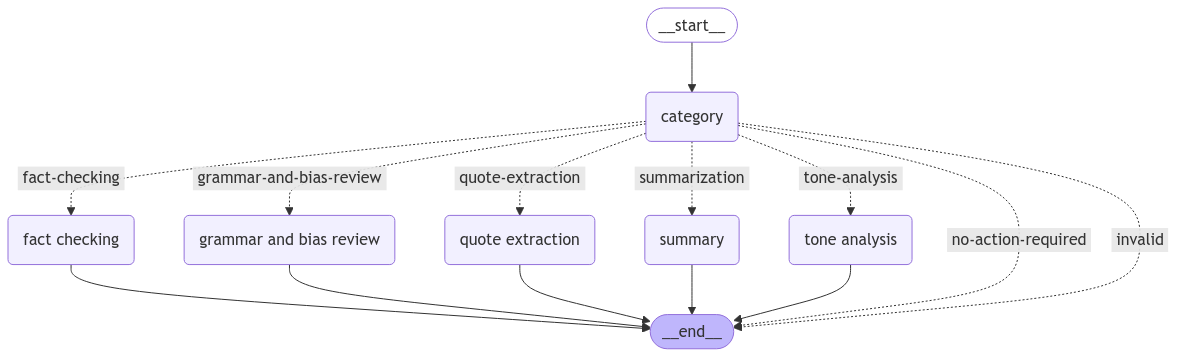

In [95]:
display(
    Image(
        journalist_assistant.get_graph().draw_mermaid_png()
    )
)

### Sample usage

In [96]:
full_report = journalist_assistant.invoke(
    {
        "current_query": "Can you provide a full report on this article?",
        "article_text": full_article_text,
    }
)

In [97]:
pprint.pprint(full_report["fact_check_result"])

[{'explanation': 'The halcyon bird is indeed celebrated in folklore as a '
                 'symbol of tranquility, particularly in relation to the '
                 'calming of winds and seas during its nesting period.',
  'statement': 'The halcyon bird is a symbol of tranquility and mythical '
               'wonder.',
  'status': 'confirmed',
  'suggested_keywords': []},
 {'explanation': "The term 'halcyon' originates from the Greek myth of "
                 'Alcyone, who was transformed into a kingfisher, which is '
                 'well-documented in classical literature.',
  'statement': "The term 'halcyon' is historically rooted in the Greek myth of "
               'Alcyone, a figure transformed into a kingfisher.',
  'status': 'confirmed',
  'suggested_keywords': []},
 {'explanation': 'The halcyon kingfisher refers to certain species of '
                 'kingfishers, particularly those in tropical and subtropical '
                 'regions, which are recognized in ornith

### Report Generation
Format the results in markdown and save them to be easier to read.


In [ ]:
def format_analysis_results(report_data):
    # Parsing and formatting each section, handling missing values as needed.

    # Actions Performed
    actions = report_data.get('actions', [])
    actions_text = "\n".join(
        f"- {action}" for action in actions) if actions else "No actions recorded."

    # Current Query
    current_query = report_data.get('current_query', 'No query provided.')

    # Summary
    summary = report_data.get('summary_result', 'No summary available.')

    # Fact-check Results
    fact_check_result = report_data.get('fact_check_result', [])
    fact_check_text = ""
    if fact_check_result:
        for fact in fact_check_result:
            statement = fact.get('statement', 'No statement provided')
            status = fact.get('status', 'Unknown')
            explanation = fact.get('explanation', 'No explanation provided')
            fact_check_text += f"\n- **Statement:** {statement}\n  - **Status:** {status}\n  - **Explanation:** {explanation}\n"

            # Adding search results
            search_results = fact.get('search_results', [])
            if search_results:
                fact_check_text += "  - **Related Search Results:**\n"
                for result_set in search_results:
                    for result in result_set:
                        title = result.get('title', 'No title available')
                        summary = result.get(
                            'summary', 'No summary available').strip().replace('\n', ' ')
                        url = result.get('url', 'No URL available')
                        fact_check_text += f"    - **Title:** {title}\n\n      - **Summary:** {summary}\n\n      - **URL:** {url}\n\n"
    else:
        fact_check_text = "No fact-check results available."

    # Grammar and Bias Review
    grammar_review = report_data.get('grammar_and_bias_review_result', ['No grammar or bias review available.'])
    grammar_review = "\n".join(grammar_review)
    
    # Tone Analysis
    tone_analysis = report_data.get('tone_analysis_result', ['No tone analysis available.'])
    tone_analysis = "\n".join(tone_analysis)

    # Quotes Extracted
    quote_extraction = report_data.get('quote_extraction_result', ['No quotes extracted.'])
    quote_extraction = "\n".join(quote_extraction)

    # Format the report
    report_structured = f"""
# Report on Article Analysis

## Query
{current_query}

## Actions Performed
{actions_text}

## Summary
{summary if summary else "No summary available."}

## Fact-check Results
{fact_check_text if fact_check_text else "No fact-check results available."}

## Grammar and Bias Review
{grammar_review if grammar_review else "No grammar or bias review available."}

## Tone Analysis
{tone_analysis if tone_analysis else "No tone analysis available."}

## Quotes Extracted
{quote_extraction if quote_extraction else "No quotes found."}

---


## Generated by your reliable AI assistant 🤖
"""

    return report_structured

In [ ]:
report_content = format_analysis_results(full_report)

# Save the report to a ArticelAnalysis.md file
report_path = data_path / "ArticleAnalysis.md"
with open(report_path, "w") as report_file:
    report_file.write(report_content)

print(f"Report saved to {report_path} file")

## Additional Considerations

While this Journalism-Focused AI Assistant provides powerful tools for enhancing journalistic practices, it’s important to acknowledge its limitations, potential areas for improvement, and specific scenarios where it excels.

### Limitations
- **Accuracy of Sources**: The reliability of fact-checking depends heavily on the quality and credibility of the sources retrieved via web searches. Results may vary depending on the availability of accurate information.
- **Bias in AI Outputs**: While tone and bias detection modules help mitigate issues, AI models themselves may occasionally introduce or miss biases due to training data limitations.
- **Real-Time Updates**: The system is not connected to live news feeds or continuously updating databases, which might limit its utility for breaking news scenarios.

### Potential Improvements
- **Real-Time Data Integration**: Connecting to live news feeds or APIs for real-time updates could enhance the relevance and timeliness of analyses.
- **Fine-Tuned Models**: Custom training or fine-tuning the AI models on journalistic datasets could improve the system’s understanding of nuances in reporting.
- **Enhanced Workflows**: Additional workflows for niche journalism use cases, such as investigative reporting or legal compliance, could increase flexibility.

### Specific Use Cases
- **Fact-Checking at Scale**: Ideal for verifying multiple claims in investigative journalism or research-heavy articles.
- **Tone and Bias Monitoring**: Helpful for ensuring balanced coverage and maintaining editorial neutrality.
- **Content Summarization**: Streamlines the review process for lengthy reports, interviews, or documents.
- **Transparent Reporting**: Quote extraction and grammar review make it easier to present clear and credible content.

By addressing these considerations, the tool can continue to evolve, becoming an even more indispensable resource for modern journalism.
